### Import Libraries and Data

In [2]:
import re
import nltk
import string
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
# import training data
trainPath = '.\Data\\train.csv'
train = pd.read_csv(trainPath)
print('training shape: ', train.shape)
display(train.head())

# test data doesn't have labels so we can't use it to evaluate model accuracy
# instead, i'll train-test-split the "train.csv" data

training shape:  (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Visualize Training Set Classes

0    255027
1    149263
Name: is_duplicate, dtype: int64

0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64


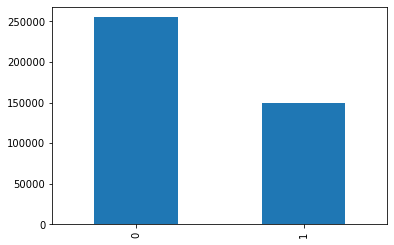

In [4]:
# number of classes
print(train["is_duplicate"].value_counts()); print() # count
print((train["is_duplicate"].value_counts()/train["is_duplicate"].count())*100) # percent

# plot 
train["is_duplicate"].value_counts().plot(kind="bar");

### Cleaning

In [5]:
# drop nan values
train = train.dropna()

# number of nan values after cleaning
print('number of null values: \n', train.isnull().sum())

number of null values: 
 id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


In [6]:
# number of duplicate values
train.duplicated().sum()

0

### Undersampling Due To Class Imbalance

before undersampling:
Counter({0: 255024, 1: 149263})

after undersampling:
Counter({0: 149263, 1: 149263})


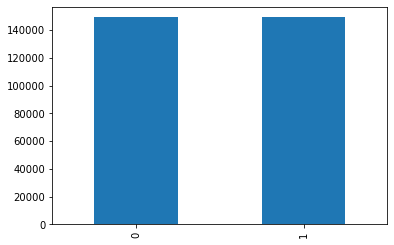

In [7]:
# random undersampling to fix class imbalance

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# summarize class distribution
print('before undersampling:')
print(Counter(train['is_duplicate'])); print()

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# fit and apply the transform
# X_train, y_train = undersample.fit_resample(X_train, y_train)
train, _ = undersample.fit_resample(train, train['is_duplicate'])

# summarize class distribution
print('after undersampling:')
print(Counter(train['is_duplicate']))

# plot
train['is_duplicate'].value_counts().plot(kind="bar");

In [8]:
# downsample for compute purposes
train = train.sample(100000, random_state=42)

print('after sampling (label counts):')
print(Counter(train['is_duplicate'])); print()
print('after sampling (label percentages):')
print((train["is_duplicate"].value_counts()/train["is_duplicate"].count())*100) # percent

after sampling (label counts):
Counter({1: 50064, 0: 49936})

after sampling (label percentages):
1    50.064
0    49.936
Name: is_duplicate, dtype: float64


### Clean Question Text

In [9]:
eng_words = set(nltk.corpus.words.words())
stopword = nltk.corpus.stopwords.words('english')

def clean_question(question):
    
    # lowercase
    question = question.lower()
    
    # remove punctuation
    question = "".join([char for char in question if char not in string.punctuation])
    
    # remove non-english words
    question = " ".join(word for word in re.split('\W+', question) if word in eng_words)
    
    # remove stopwords
    question = " ".join([word for word in re.split('\W+', question) if word not in stopword])

    return question

In [10]:
# clean question1 and update dataframe
for idx, question in enumerate(train['question1']):
    train['question1'].iloc[idx] = clean_question(question)
    
# clean question2 and update dataframe
for idx, question in enumerate(train['question2']):
    train['question2'].iloc[idx] = clean_question(question)
    
# drop rows with empty questions after cleaning
train['question1'].replace('', np.nan, inplace=True)
train['question2'].replace('', np.nan, inplace=True)
train = train.dropna(how='any')

print(train.shape) # will be slightly less than 100k
train.head() # questions should be cleaned

C:\Users\ta1031742\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(97122, 6)


,id,qid1,qid2,question1,question2,is_duplicate
284788,364720,494790,484904,god hate made,god homosexuality make possible,1
231577,221233,328525,328526,photon retina eye,photon go retina,1
109421,121761,197246,197247,legitimate beating best,history star,0
47536,249661,363349,195254,new know going first day stage,new know going first day,0
228283,212447,9163,46561,best coaching,coaching institute best location want score,1


### Train-Test-Split

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train[['question1', 'question2']], train['is_duplicate'], test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape); print()

print('----------------------------------------------------------------')
print('Now go to Count/TFIDF vectorization OR GloVe word embeddings.')
print('----------------------------------------------------------------')

X_train shape:  (77697, 2)
y_train shape:  (77697,)
X_test shape:  (19425, 2)
y_test shape:  (19425,)

----------------------------------------------------------------
Now go to Count/TFIDF vectorization OR GloVe word embeddings.
----------------------------------------------------------------


### Count and TFIDF Vectorization - DONE 

In [20]:
# concat questions for vectorization
train_questions = list(X_train['question1']) + list(X_train['question2'])
test_questions = list(X_test['question1']) + list(X_test['question2'])

In [21]:
# initialize vectorizer
# vec = TfidfVectorizer(max_features=3000)
vec = CountVectorizer(max_features=3000)

# fit vectorizer of training questions
vec = vec.fit(train_questions)

# transform training and test questions
train_questions_vectorized = vec.transform(train_questions)
test_questions_vectorized = vec.transform(test_questions)

# split
train_q1, train_q2 = np.vsplit(train_questions_vectorized.toarray(),2)
test_q1, test_q2 = np.vsplit(test_questions_vectorized.toarray(),2)

# concatenate along column axis
train_all_qs = np.concatenate((train_q1, train_q2), axis=1)
test_all_qs = np.concatenate((test_q1, test_q2), axis=1)

# turn to dataframe
X_train = pd.DataFrame(train_all_qs)
X_test = pd.DataFrame(test_all_qs)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# print shapes
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

q1 shape:  (77697, 3000)
q2 shape:  (77697, 3000)


In [23]:
# save data - change name of file!!!
with open('countvec.pickle', 'wb') as handle:
    pickle.dump([X_train, X_test, y_train, y_test], handle, protocol=pickle.HIGHEST_PROTOCOL)

### GloVe Word Embeddings - DONE

In [32]:
# proprocess questions
train_questions = list(X_train['question1']) + list(X_train['question2'])
test_questions = list(X_test['question1']) + list(X_test['question2'])

# prepare tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_questions)

# create the word_index dictionary 
word_index = tokenizer.word_index

# get the vocabulary
vocabulary = list(word_index.keys())
print('vocabulary length: ', len(vocabulary))

# convert questions into sequences (integer encoding)
sequences_train = tokenizer.texts_to_sequences(train_questions)
sequences_test = tokenizer.texts_to_sequences(test_questions)

# pad sequences so all have same length
max_len = 50
sequences_train = pad_sequences(sequences_train, maxlen=max_len, padding='post')
sequences_test = pad_sequences(sequences_test, maxlen=max_len, padding='post')

vocabulary length:  15056


In [33]:
# split
train_q1, train_q2 = np.vsplit(sequences_train, 2)
test_q1, test_q2 = np.vsplit(sequences_test, 2)

# concatenate along column axis
train_all_qs = np.concatenate((train_q1, train_q2), axis=1)
test_all_qs = np.concatenate((test_q1, test_q2), axis=1)

# turn to dataframe
X_train = pd.DataFrame(train_all_qs)
X_test = pd.DataFrame(test_all_qs)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# print shapes
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (77697, 100)
y_train shape:  (77697,)
X_test shape:  (19425, 100)
y_test shape:  (19425,)


In [35]:
# load glove dictionary
glove_dictionary = {}
with open('glove.6B.200d.txt', encoding="utf8") as file:
    for each_line in file:
        words, coeffs = each_line.split(maxsplit=1)
        coeffs = np.array(coeffs.split(),dtype = float)
        glove_dictionary[words] = coeffs

In [36]:
# create embedding matrix
embedding_matrix = np.zeros((len(vocabulary), 200)) 

# loop through all vocab words
for idx, word in enumerate(vocabulary):
    if word in list(glove_dictionary.keys()):
        embedding_matrix[idx:] = glove_dictionary[word]

In [37]:
# save variables
with open('glovewordembeddings.pickle', 'wb') as handle:
    pickle.dump([X_train, X_test, y_train, y_test, embedding_matrix], handle, protocol=pickle.HIGHEST_PROTOCOL)

### Word2Vec Embeddings - TO DO

Bag of words approaches (Count, TFIDF, One-hot): hold no information about the meaning of the word, how it is used in language and what is its usual context (i.e. what other words it generally appears close to).

Word embeddings: capture the context of the word. Similar words will share similar vector representations. 

In [ ]:
# get word2vec file and extract

# !pip install wget
# import wget
# import gzip

# url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
# filename = wget.download(url)

# f_in = gzip.open('GoogleNews-vectors-negative300.bin.gz', 'rb')
# f_out = open('GoogleNews-vectors-negative300.bin', 'wb')
# f_out.writelines(f_in)

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(vocabulary, vector_size=24, epochs=100)
word_vectors = model.wv

In [ ]:
from tensorflow.keras.layers import Embedding

def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer